<a href="https://colab.research.google.com/github/varinen/handson-unsupervised-learning/blob/master/Chap11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Detection Using Deep Belief Networks

Deep Belief Networks have been introduced by Geoff Hinton in 2006. Restricted Boltzmann machines have only two layers: visible and invisible. They are shallow network and are not able to capture com plex relationships in data like images, text and other. 

RBMs can be stacked so that the hidden layer of one RBM becomes the visible layer of another. This feature forms deep belief networks that consist of multiple layers and are capable of learning complex data.

In the last decade, other forms of deep learning have surpassed Deep Belief Networks in performance.


## Deep Belief Networks in Details

Like RBMs, DBNs learn the underlying structure of input and can probabilistically reconstruct it. DBNs like RBMs are generative models.

Like in RBMs, neurons in one layer of a DBN can connect only to neurons in other layers bit to neurons within the same layer. DBNs are trained one layer at a time starting from the first hidden layer. The trained hidden layer then becomes the input layer of the next RBM. Except for the first and final layers, each layer in a DBN is both an input and a hidden layer of an RBM.

The training of the hidden layers in a DBN does not require labels. If we have labels and need to perform the classification, we can apply the labels to the final layer to fine-tune the training. Thus, the training performed before is unsupervised and is called *pre-training*. The use of labels in the final layer is called *fine-tuning*.


## MNIST Image Classification

Let's use DBNs to classify images in the MNIST dataset. First, we need a few imports:



In [0]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
current_path = 'gdrive/My Drive/Colab Notebooks/datasets/mnist/'
file  = 'mnist.pkl.gz'

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [0]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


We will encode labels as one-hot vectors:

In [0]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [0]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,0.000037,0.000017,7.031250e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,0.000044,0.000108,0.000155,0.000210,0.000380,0.000570,...,0.013975,0.010081,0.006603,0.003967,0.002168,0.001039,0.000333,0.000067,2.343750e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000067,0.000173,0.000377,0.000501,0.000709,0.001159,0.001440,0.001910,0.002044,0.002479,0.002171,0.001725,0.001215,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002034,0.005825,0.003773,1.572223e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000280,0.000833,0.004514,0.008921,0.010814,0.012095,0.016715,0.020658,...,0.102319,0.086386,0.070681,0.054545,0.041041,0.027224,0.014586,0.005078,5.240772e-05,0.001031,0.0,0.0,0.0,0.0,0.0,0.0,0.001872,0.007228,0.010340,0.016519,0.019057,0.023204,0.027897,0.032083,0.037493,0.037788,0.042872,0.039894,0.034695,0.029488,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [0]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [0]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

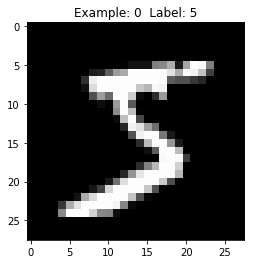

In [0]:
# View the first digit
view_digit(X_train, y_train, 0)

In [0]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [0]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [0]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [0]:
y_train_oneHot.shape

(50000, 10)

In [0]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

## Restricted Boltzmann Machines

Now, we need to define a class for RBMs so that we can train several of them in a succession that forms a DBN.

Recall that: 
 - RBMs have two layers: visible and hidden.
 - Neurons in one layer can connect to neurons in other layers but not to neurons in the same layer.
 - Communication between layers goes in both direction.
 
The visible layer receives input and passes it to the hidden layer. The hidden layer generates a representation from the learned data structure and passes it back to the visible layer. The visible layer samples the result, compares it to the original data and adjusts the weights before sending the data to the hidden layer one more time.

By communicating in both directions a RBM can produce a generative model such that the output of the hidden layer is similar to the input.

### Build Components of the RBM Class

We will need to initialize an RBM instance with hyperparameters such as the sizes of the visible and hidden layers, batch size, learning rate, and the number of epochs. We will also define zero matrices for weights, hidden and visible bias vectors.



In [0]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        """Forward pass.
        :param visible: input fro mthe visible layer
        :param w: matrix of weights
        :param hb: bias vector of the hidden layer
        """
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        """Backward pass.
        :param hidden: output of the hidden layer
        :param w: matrix of weights
        :param vb: bias vector of the visible layer
        """
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        """Sample the output.
        :param probs: probabilities to sample from
        """
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        """Train the RBM.
        :param X: training input data
        """
        # Prepare placeholderes for the weights, hidden and visible
        # bias vectors        
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        # Computation of positive and negative gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        # Weight adjustments using MSE as the reconstruction error
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        # Record the current reconstruction error
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        # Train for the predefined number of epochs
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                # Train in batches
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):    
        """Generate new images from the learned generative model.
        :param X: input data
        """
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
        
    def show_features(self, shape, suptitle, count=-1):
        """View the intermediate feature detectors."""
        # Maximum value in the array
        maxw = np.amax(self.w.T)
        # Minimum value in the array
        minw = np.amin(self.w.T)
        
        # Count of features to display, max equal to the output size
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        
        # Number of columns, max 14
        ncols = count if count < 14 else 14 
        # Number of rows, min 3
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        
        # Prepare a figure and a grid to display
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        
        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            
            # reshape into a 1D vector with length equal the number of elements
            # (One shape dimension can be -1. In this case, the value is 
            # inferred from the length of the array and remaining dimensions).
            x = (x.reshape(1, -1) - minw)/maxw
            
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

## Train the Three RBMs for a DBN

We now will use the prepared class to create a DBN consisting of three stacked RBMs. The first RBM will take the original 784 feature  vector and output a 700-dimension matrix. This will be fed into the second RBM that will produce a 600-dimension matrix. The final RBM will take the 600-dimensional matrix and output a 500-dimension matrix.

Note that we store the three RBMs in an array and convert the input data to integers.

In [0]:
# Since we are training, set input as training data
inputX = np.array(X_train)
inputX = inputX.astype(np.float32)

# Create list to hold our RBMs
rbm_list = []

# Define the parameters of the RBMs we will train
rbm_list.append(RBM(784,700,1.0,100,200))
rbm_list.append(RBM(700,600,1.0,100,200))
rbm_list.append(RBM(600,500,1.0,100,200))

We now will train the RBMs and store the output in the `outputList` list. Note that we use the `rbm_output` method of the `RBM` class to generate the output matrix (the hidden layer) to be used as the input layer of the subsequent RBM.

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16771651277588793775
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2086253576023341468
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
outputList = []
error_list = []
#For each RBM in our list
for i in range(0,len(rbm_list)):
    print('RBM', i+1)
    #Train a new one
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)
    #Return the output layer
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX = hiddenX

W0701 14:24:01.558585 139835113891712 deprecation.py:323] From <ipython-input-16-be302b0bb061>:67: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


RBM 1
Epoch: 0 reconstruction error: 0.074369
Epoch: 1 reconstruction error: 0.064809
Epoch: 2 reconstruction error: 0.059018
Epoch: 3 reconstruction error: 0.054998
Epoch: 4 reconstruction error: 0.052903
Epoch: 5 reconstruction error: 0.050558
Epoch: 6 reconstruction error: 0.049189
Epoch: 7 reconstruction error: 0.048222
Epoch: 8 reconstruction error: 0.047017
Epoch: 9 reconstruction error: 0.046489
Epoch: 10 reconstruction error: 0.045531
Epoch: 11 reconstruction error: 0.044800
Epoch: 12 reconstruction error: 0.044146
Epoch: 13 reconstruction error: 0.043879
Epoch: 14 reconstruction error: 0.043643
Epoch: 15 reconstruction error: 0.043376
Epoch: 16 reconstruction error: 0.043217
Epoch: 17 reconstruction error: 0.043002
Epoch: 18 reconstruction error: 0.042479
Epoch: 19 reconstruction error: 0.042427
Epoch: 20 reconstruction error: 0.042041
Epoch: 21 reconstruction error: 0.042279
Epoch: 22 reconstruction error: 0.041649
Epoch: 23 reconstruction error: 0.041868
Epoch: 24 reconstruc

The errors of RBMs decline the longer we train them. Let's see them on the graphs:

RBM 1


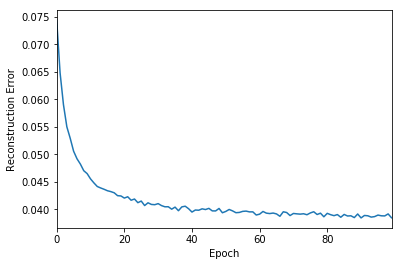

RBM 2


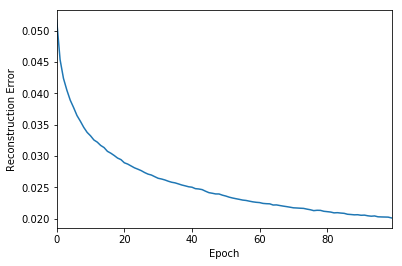

RBM 3


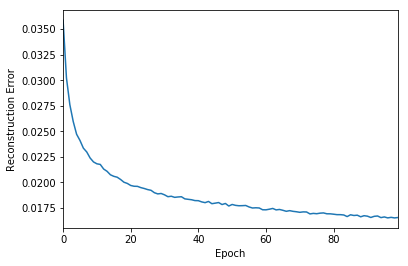

In [0]:
# Plot reconstruction errors
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

### Examine Feature Detectors

Now let's see how the learned features (weight matrix rows) look like in the outputs of each RBMs.

RBM 0


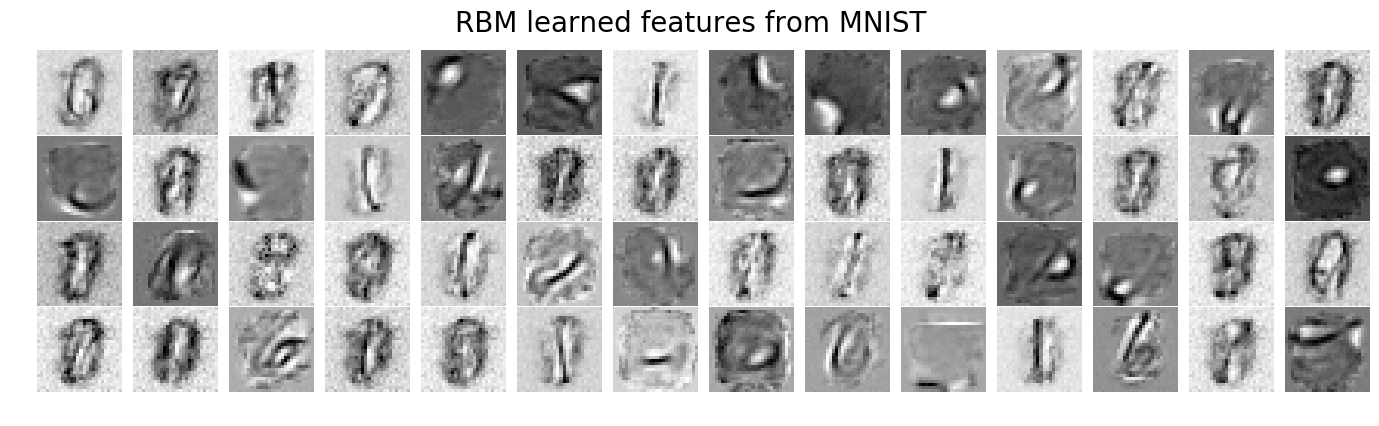

None
RBM 1


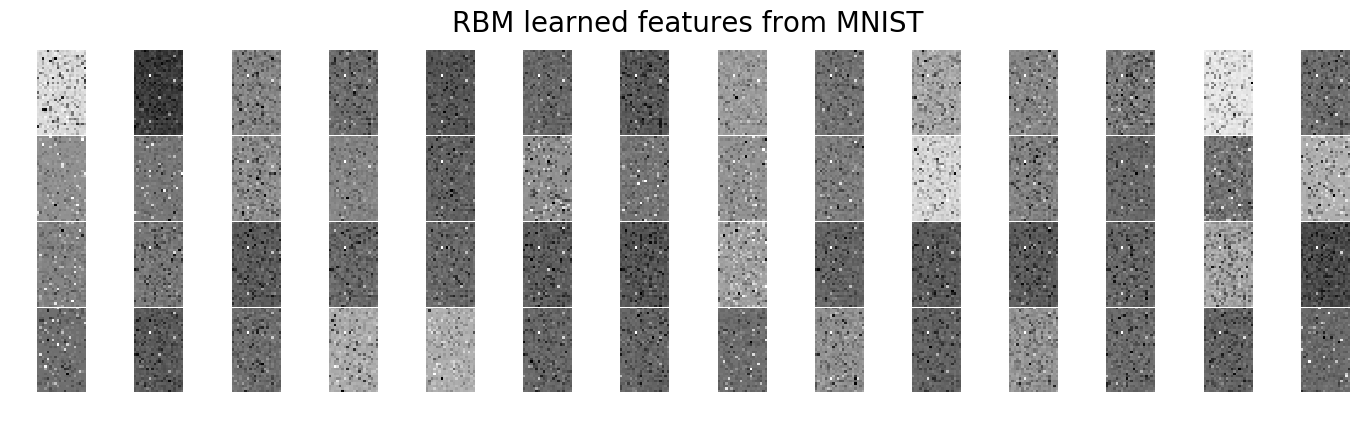

None
RBM 2


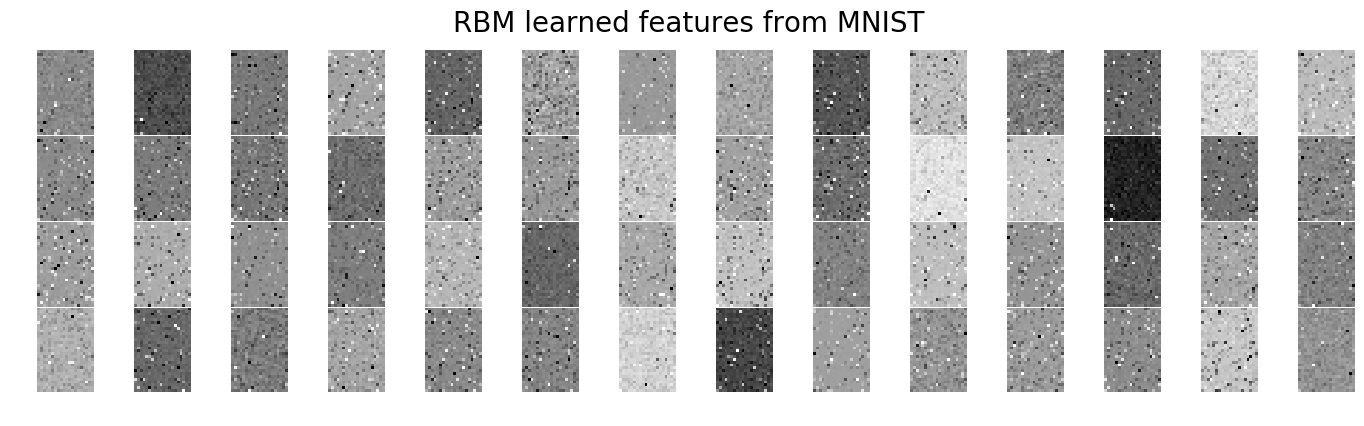

None


In [0]:
# Examine Feature Detectors
rbm_shapes = [(28,28),(35,20),(30,20)]
for i in range(0,len(rbm_list)):
    rbm = rbm_list[i]
    print("RBM",i)
    print(rbm.show_features(rbm_shapes[i], \
                            "RBM learned features from MNIST", 56))

While the output of the first RBM still resembles digits, the outputs of the consecutive RBMs are more abstract. This is normal for networks like this as each layer learns more and more abstract underlying data structures.


### View Generated Images

Before we continue to train the full DBN, we should look how the current setup generates images. We will use inly the first RBM. To its input we will feed the MNIST dataset and it will perform the forward and backward passes and generate an image we need We will comptare the first 10 images from the dataset to their generated versions.



RBM 1
Image generated by RBM


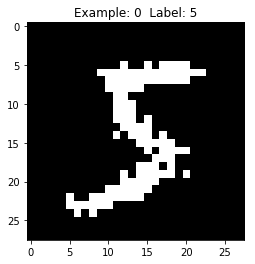

Original image


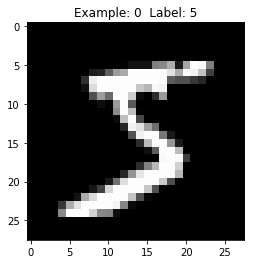

Image generated by RBM


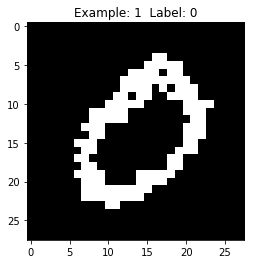

Original image


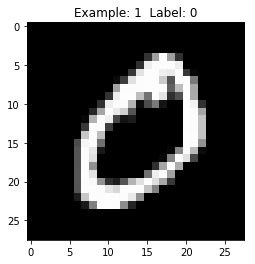

Image generated by RBM


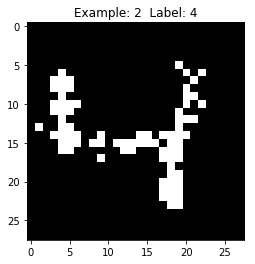

Original image


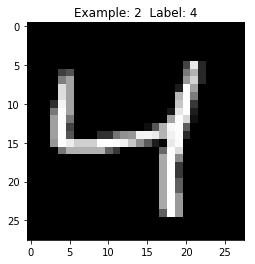

Image generated by RBM


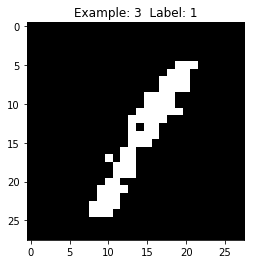

Original image


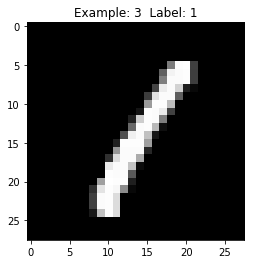

Image generated by RBM


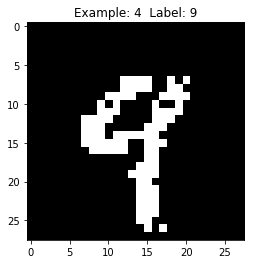

Original image


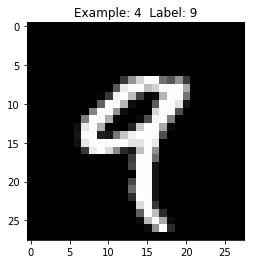

Image generated by RBM


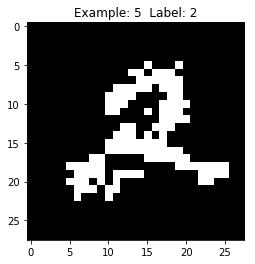

Original image


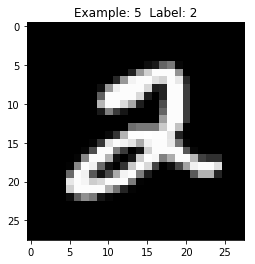

Image generated by RBM


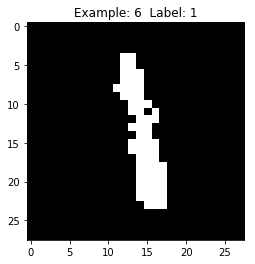

Original image


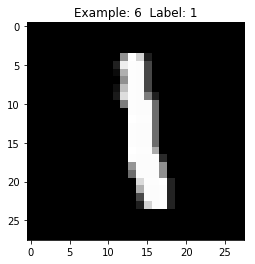

Image generated by RBM


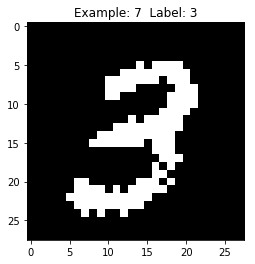

Original image


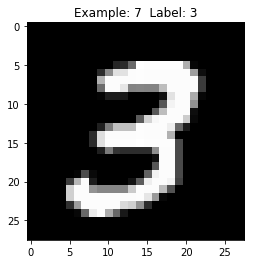

Image generated by RBM


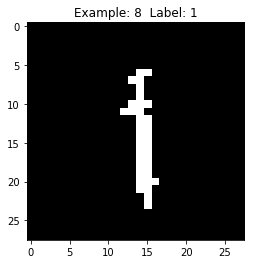

Original image


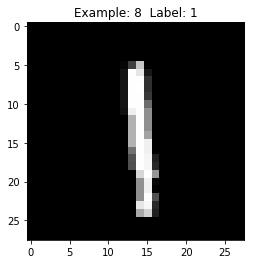

Image generated by RBM


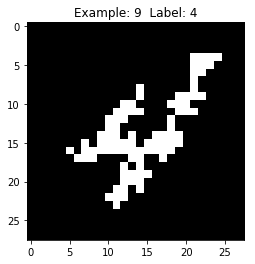

Original image


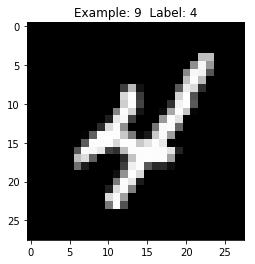

In [0]:
# View generated images from the first RBM
inputX = np.array(X_train)
rbmOne = rbm_list[0]

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = \
                            rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, \
                                     index=X_train.index)
for j in range(0,10):
    example = j
    print("Image generated by RBM")
    view_digit(reconstructedX_rbmOne, y_train, example)
    print("Original image")
    view_digit(X_train, y_train, example)

## Full DBN

Now, let's build a full DBM that includes the tree RBM that we trained before plus a fourth one on top of them that will perform forward and backward passes to fine tune the generative model using the available labels.

As before, we have to define a class to implement the DBN functionality and set up hyperparameters that will include:

- input and output sizes
- learning rate
- epoch number
- batch size
- three pre-trained RBMs

We will also define zero matrices for  the hidden and visible layers' bias vectors, and a zeros matrix for weights.

In [0]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # Define hyperparameters
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        """Perform forward pass.
        :param visible: input vector from the visible layer
        :param w: weights
        :param hb: hidden bias vector
        """
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        """Perform backward pass.
        :param hidden: output of the hidden layer
        :param w: weights
        :param hb: hidden bias vector
        """
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        """Sample the probabilities.
        :param probs: probabilities to sample from.
        """
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        """Train the machine.
        :param X: training inputs
        """
        # Placeholders fot the weight matrix and bias vectors
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        # Storage arrays for the weights and biases from the previous iteration
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        # Storage arrays for the current weights and biases 
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        # Placeholder for the input layer
        v0 = tf.placeholder("float", [None, self._original_input_size])

        # Forward pass through three internal pre-trained RBMs
        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, \
                        self.rbmOne.w) + self.rbmOne.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + \
                        self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, \
                        self.rbmThree.w) + self.rbmThree.hb) - \
                        tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul( \
                        forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        
        # Sampling probabilities of the hidden and visible layers' outputs.
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        # Contrastive divergence
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        # Updates to the weights and biases
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / \
                        tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
       
        # Backward pass through the three internal RBMs
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, \
                            self.rbmThree.w.T) + self.rbmThree.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(v1, self.rbmThree.w.T) + \
                            self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, \
                            self.rbmTwo.w.T) + self.rbmTwo.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardOne, self.rbmTwo.w.T) + \
                            self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, \
                            self.rbmOne.w.T) + self.rbmOne.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardTwo, self.rbmOne.w.T) + \
                            self.rbmOne.vb)))))
        
        # Calculate the reconstruction loss
        err = tf.reduce_mean(tf.square(v0 - backward))
        error_list = []
        
        
        # Train the model
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
              
                # Train in batches
                for start, end in zip(range(0, len(X), self.batchsize), \
                        range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: \
                                    cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
        
    def dbn_output(self, X):
        """Produce the generated images from the hidden and visible layers'
        outputs
        :param X: input to r
        """
        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + \
                                   self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + \
                                   self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + \
                                self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + \
                                    self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + \
                                    self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + \
                                 self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

    def show_features(self, shape, suptitle, count=-1):
        """Show the most prominent features."""
        # Max weight in the weight matrix
        maxw = np.amax(self.w.T)
        # Min weight in the weight matrix
        minw = np.amin(self.w.T)
        
        # Define hoe many features needed to be displayed
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        
        # Define to columns for the feature display, max 14
        ncols = count if count < 14 else 14 
        
        # Define the number of rows for the display, min 3
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        
        # Set up a figure and a grid to output the images
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        # Display a feature (weight vector) as an image
        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

### How Training of DBN Works

To train the DBN we are using the previously trained RBMs to perform pre-training. These 3 RBMs alredy have their weight matrices, visible and hidden bias vectors defined during their training, they will not be adjusted in this phase. We will use them as static components of the DBN.

It is the forth RBM that will be trained. It will receive as input not the original images, but their representation generated by passing the input through the three static RBMs. It will then use the reconstruction error to adjust its weights and biases to get a refined representation of the original images.

It is possible to train a DBN so that the what are now statiic RBM get their weights and biases adjusted as well. This, however, is computationally intensive and will not be attempted at this time.


### Train the DBN

We will set the original input size to 784, the output size of the third RBM to 500, and the desired output size to 500 as well. We will train with the learning rate of 1.0 for 50 epochs in 200 batches:

In [0]:
# Instantiate DBN Class
dbn = DBN(784, 500, 500, 1.0, 50, 200, rbm_list[0], rbm_list[1], rbm_list[2])

In [0]:
inputX = np.array(X_train)
error_list = []
error_list = dbn.train(inputX)

Epoch: 0 reconstruction error: 0.086037
Epoch: 1 reconstruction error: 0.077990
Epoch: 2 reconstruction error: 0.074717
Epoch: 3 reconstruction error: 0.073041
Epoch: 4 reconstruction error: 0.071659
Epoch: 5 reconstruction error: 0.070493
Epoch: 6 reconstruction error: 0.069643
Epoch: 7 reconstruction error: 0.069125
Epoch: 8 reconstruction error: 0.068274
Epoch: 9 reconstruction error: 0.067741
Epoch: 10 reconstruction error: 0.067614
Epoch: 11 reconstruction error: 0.067066
Epoch: 12 reconstruction error: 0.066761
Epoch: 13 reconstruction error: 0.066511
Epoch: 14 reconstruction error: 0.065899
Epoch: 15 reconstruction error: 0.065657
Epoch: 16 reconstruction error: 0.065407
Epoch: 17 reconstruction error: 0.065326
Epoch: 18 reconstruction error: 0.064884
Epoch: 19 reconstruction error: 0.064780
Epoch: 20 reconstruction error: 0.064638
Epoch: 21 reconstruction error: 0.064209
Epoch: 22 reconstruction error: 0.063933
Epoch: 23 reconstruction error: 0.064040
Epoch: 24 reconstruction e

Let's see how the reconstruction error declines with the training

DBN


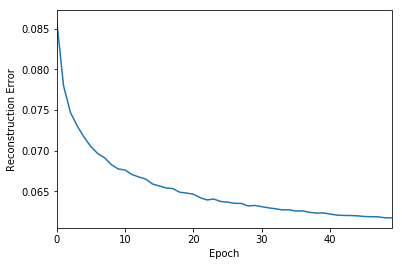

In [0]:
# Plot reconstruction errors
print("DBN")
pd.Series(error_list).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

As expected, the features learned by the output layer of the final RBM are very abstract:


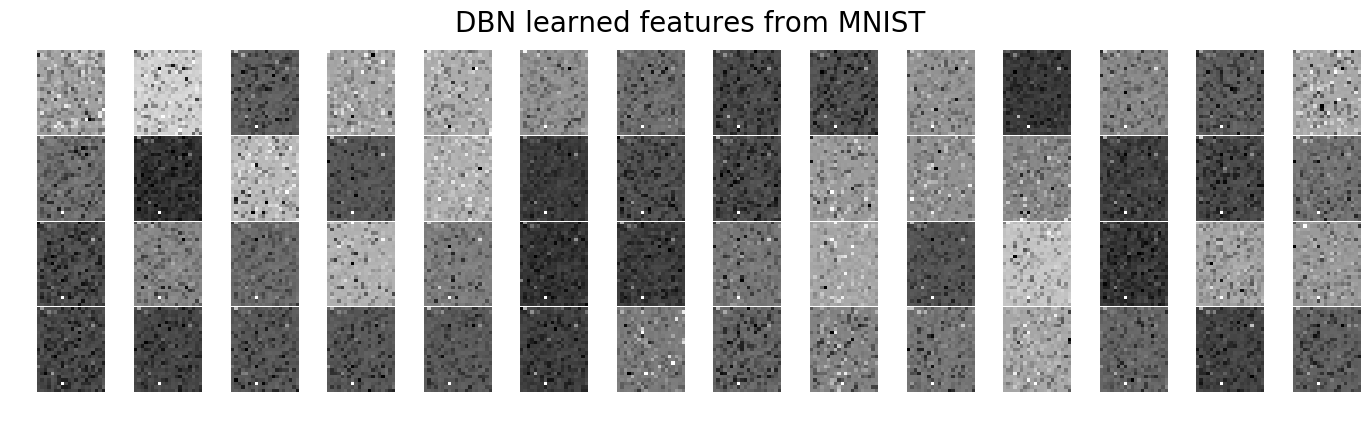

None


In [0]:
print(dbn.show_features((25,20),"DBN learned features from MNIST", 56))


## How Unsupervised Learning Helps Supervised Learning

We have been experimenting with a DBN without using any labeled data. The DBN was capable to learn from the input data itself a model that can generate images very similar to the originals. 

Recall that in real world problems there not always enough labeled data. If the MNIST dataset had not 50000 samples but only a fraction of them, say, 5000 then any supervised classifier would not be as effective with 5000 as it could have been with 50000.

Here, an unsupervised algorithm can be used to generate enough labeled data to allow a supervised algorithm to learn effectively.


### Generate Images to Build a Better Image Classifier

To simulate a situation with insufficient labeled data, let's reduce the original MNIST dataset to 5000 samples and store them in a DataFrame called  `inputXreduced`. Then, we will use these 5000 labeled elements to get 20 times as many labeled samples using the generative model we have trained in the DBN. We will store the hidden layer outputs of the form RBM, but also we will be storing the generated images for later evaluation.

In [0]:
# Generate images and store them
inputXReduced = X_train.loc[:4999]
for i in range(0,20):
    print("Run ",i)
    finalOutput_DBN, reconstructedOutput_DBN = dbn.dbn_output(inputXReduced)
    if i==0:
        generatedImages = finalOutput_DBN
    else:
        generatedImages = np.append(generatedImages, finalOutput_DBN, axis=0)

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19


We will replicate the original label vector 20 times and apply it to the generated images

In [0]:
# Generate a vector of labels for the generated images
for i in range(0,20):
    if i==0:
        labels = y_train.loc[:4999]
    else:
        labels = np.append(labels,y_train.loc[:4999])

Finally, we will need to generate a validation set based on the original validation values. We will use it to evaluate the classifier we are going to build.

In [0]:
# Generate images based on the validation set
inputValidation = np.array(X_validation)
finalOutput_DBN_validation, reconstructedOutput_DBN_validation = \
    dbn.dbn_output(inputValidation)

Let's view a few of the reconstructed images:

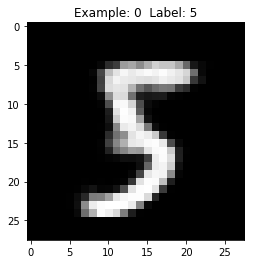

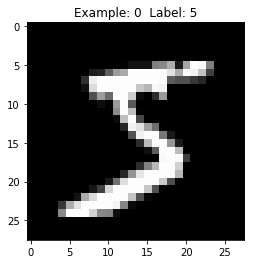

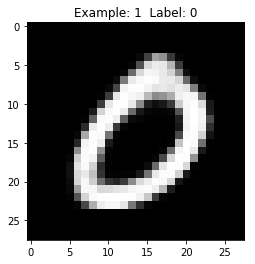

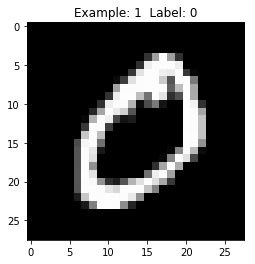

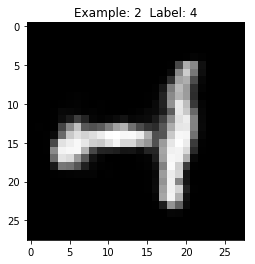

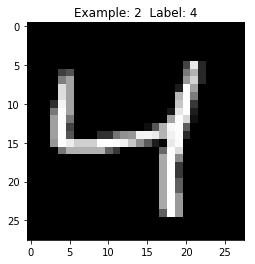

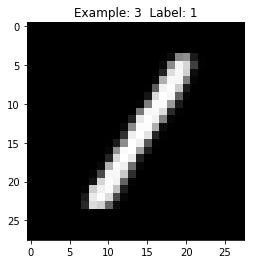

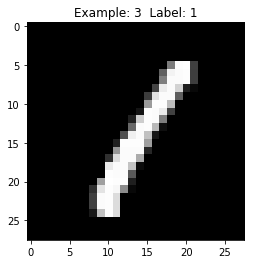

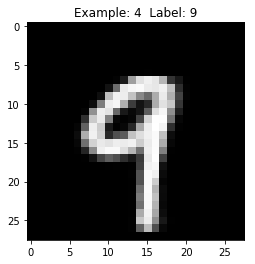

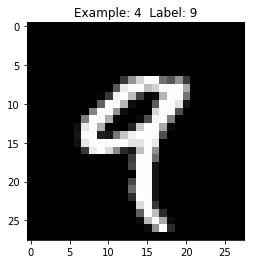

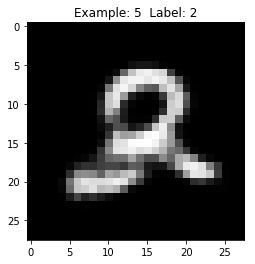

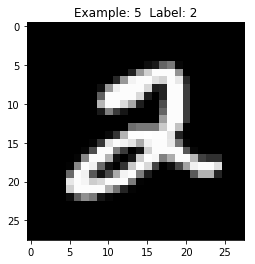

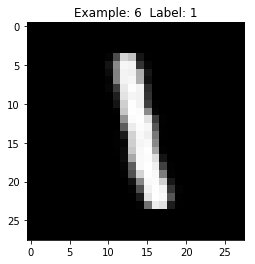

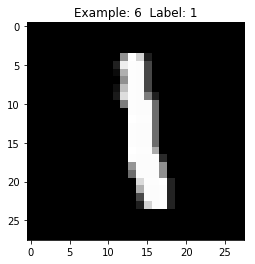

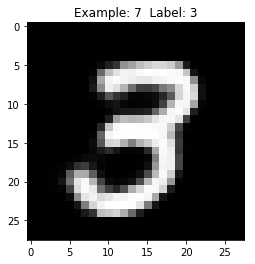

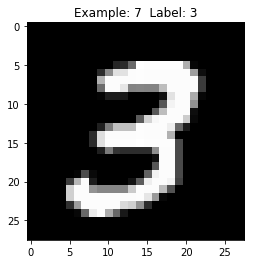

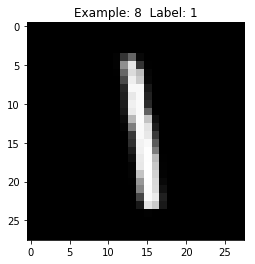

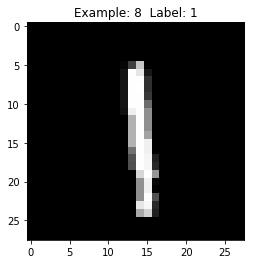

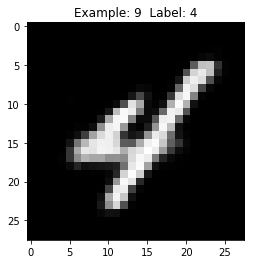

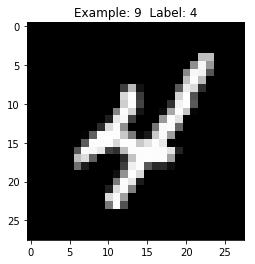

In [0]:
# View first few reconstructed images
for i in range(0,10):
    example = i
    reconstructedX = pd.DataFrame(data=reconstructedOutput_DBN, \
                                  index=X_train[0:5000].index)
    view_digit(reconstructedX, y_train, example)
    view_digit(X_train, y_train, example)

Note that the DBN model (and its constituent RBMs) is generative and produces images using a stochastic and not a deterministic approach. This means, images will be slightly different from one DBN run to another.

To demonstrate this, we will take the first MNIST image and generate 10 versions of it:

Run  0
Generated


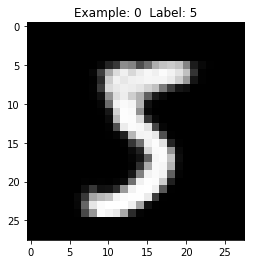

Run  1
Generated


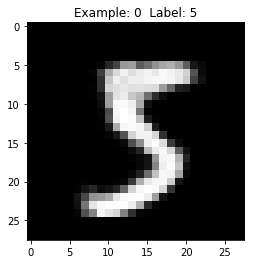

Run  2
Generated


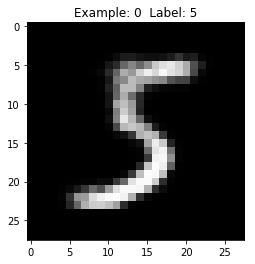

Run  3
Generated


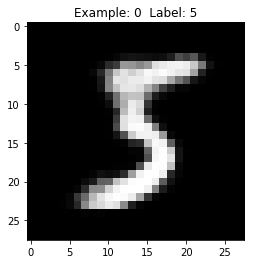

Run  4
Generated


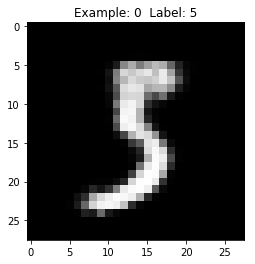

Run  5
Generated


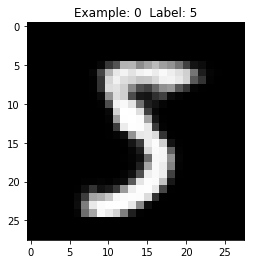

Run  6
Generated


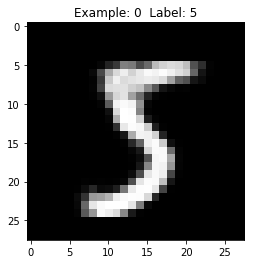

Run  7
Generated


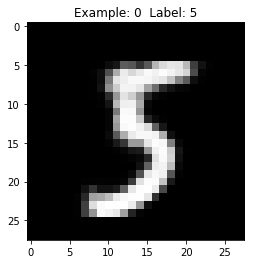

Run  8
Generated


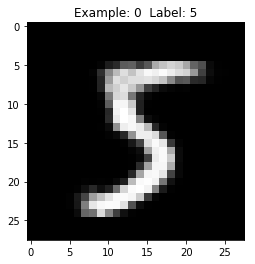

Run  9
Generated


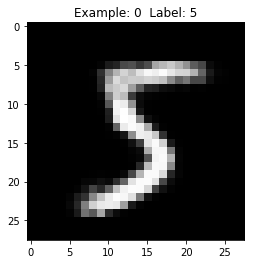

In [0]:
# Generate the first examp times
inputXReduced = X_train.loc[:0]
for i in range(0,10):
    example = 0
    print("Run ",i)
    finalOutput_DBN_fives, reconstructedOutput_DBN_fives = \
        dbn.dbn_output(inputXReduced)
    reconstructedX_fives = pd.DataFrame(data=reconstructedOutput_DBN_fives, \
                                        index=[0])
    print("Generated")
    view_digit(reconstructedX_fives, y_train.loc[:0], example)

## Image Classifier Using LighGBM

We have already used this algorithm before and will try it again to build a classifier to this MNIST experiment.

### Supervised Only

The first version of the classifier will rely only on the available reduced labeled set of 5000 samples.

In [0]:
predictionColumns = ['0','1','2','3','4','5','6','7','8','9']

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':10,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

We will train it on the 5000 labeled set and validate on the original 10000 MNIST validation set:

In [0]:
trainingScore = []
validationScore = []
predictionsLightGBM = pd.DataFrame(data=[], \
                        index=y_validation.index, \
                        columns=predictionColumns)

lgb_train = lgb.Dataset(X_train.loc[:4999], y_train.loc[:4999])
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(y_train.loc[:4999], \
    gbm.predict(X_train.loc[:4999], num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsLightGBM.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsLightGBM.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossLightGBM = log_loss(y_validation, predictionsLightGBM)
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBM)

[1]	valid_0's multi_logloss: 2.03454
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.83525
[3]	valid_0's multi_logloss: 1.67519
[4]	valid_0's multi_logloss: 1.54476
[5]	valid_0's multi_logloss: 1.43551
[6]	valid_0's multi_logloss: 1.3405
[7]	valid_0's multi_logloss: 1.25821
[8]	valid_0's multi_logloss: 1.18576
[9]	valid_0's multi_logloss: 1.11769
[10]	valid_0's multi_logloss: 1.05417
[11]	valid_0's multi_logloss: 0.998275
[12]	valid_0's multi_logloss: 0.946335
[13]	valid_0's multi_logloss: 0.900563
[14]	valid_0's multi_logloss: 0.858236
[15]	valid_0's multi_logloss: 0.820315
[16]	valid_0's multi_logloss: 0.786376
[17]	valid_0's multi_logloss: 0.754031
[18]	valid_0's multi_logloss: 0.723755
[19]	valid_0's multi_logloss: 0.696682
[20]	valid_0's multi_logloss: 0.670898
[21]	valid_0's multi_logloss: 0.645592
[22]	valid_0's multi_logloss: 0.623957
[23]	valid_0's multi_logloss: 0.601312
[24]	valid_0's multi_logloss: 0.582042
[25]	valid_0's multi_

The following are the values of the training and validation log loss from this supervised-only solution:

Training Log Loss:  0.0013000337911290725

Validation Log Loss:  0.19074588942001713

LightGBM Gradient Boosting Log Loss:  0.19074588942001713


Below, see the accuracy of the supervised-only classifier:

In [0]:
predictionsLightGBM_firm = np.argmax(np.array(predictionsLightGBM), axis=1)
accuracyValidation_lightGBM = accuracy_score(np.array(y_validation), \
                                            predictionsLightGBM_firm)
print("Supervised-Only Accuracy: ", accuracyValidation_lightGBM)

Supervised-Only Accuracy:  0.9437


## Unsupervised and Supervised Solution

Now, instead of using the reduced original dataset, let's train the classifier on the much bigger set of 100000 generated samples.

In [0]:
# Prepare DBN-based DataFrames for LightGBM use
generatedImagesDF = pd.DataFrame(data=generatedImages,index=range(0,100000))
labelsDF = pd.DataFrame(data=labels,index=range(0,100000))

X_train_lgb = pd.DataFrame(data=generatedImagesDF,
                           index=generatedImagesDF.index)
X_validation_lgb = pd.DataFrame(data=finalOutput_DBN_validation,
                                index=X_validation.index)

In [0]:
# Train LightGBM
trainingScore = []
validationScore = []
predictionsDBN = pd.DataFrame(data=[],index=y_validation.index,
                              columns=predictionColumns)

lgb_train = lgb.Dataset(X_train_lgb, labels)
lgb_eval = lgb.Dataset(X_validation_lgb, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(labelsDF, gbm.predict(X_train_lgb, \
                            num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsDBN.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation_lgb, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsDBN.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossDBN = log_loss(y_validation, predictionsDBN)
print('LightGBM Gradient Boosting Log Loss: ', loglossDBN)

[1]	valid_0's multi_logloss: 1.94555
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.70582
[3]	valid_0's multi_logloss: 1.52579
[4]	valid_0's multi_logloss: 1.37962
[5]	valid_0's multi_logloss: 1.25554
[6]	valid_0's multi_logloss: 1.15198
[7]	valid_0's multi_logloss: 1.06085
[8]	valid_0's multi_logloss: 0.980665
[9]	valid_0's multi_logloss: 0.908752
[10]	valid_0's multi_logloss: 0.845036
[11]	valid_0's multi_logloss: 0.788431
[12]	valid_0's multi_logloss: 0.737992
[13]	valid_0's multi_logloss: 0.69124
[14]	valid_0's multi_logloss: 0.649212
[15]	valid_0's multi_logloss: 0.611302
[16]	valid_0's multi_logloss: 0.577165
[17]	valid_0's multi_logloss: 0.5459
[18]	valid_0's multi_logloss: 0.517176
[19]	valid_0's multi_logloss: 0.490553
[20]	valid_0's multi_logloss: 0.466432
[21]	valid_0's multi_logloss: 0.443877
[22]	valid_0's multi_logloss: 0.423341
[23]	valid_0's multi_logloss: 0.404593
[24]	valid_0's multi_logloss: 0.387132
[25]	valid_0's multi

Let's compare the overall accuracy to the supervised solution:

In [0]:
# DBN
predictionsDBN_firm = np.argmax(np.array(predictionsDBN), axis=1)
accuracyValidation_DBN = accuracy_score(np.array(y_validation), \
                                        predictionsDBN_firm)
print("DBN-Based Solution Accuracy: ", accuracyValidation_DBN)


DBN-Based Solution Accuracy:  0.9557


The accuracy has been improved almost by one percentage point. This is impressive and shows how generative models can be used in supervised learning.